In [1]:
import os
import glob
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from PIL import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from skimage.feature import graycomatrix, graycoprops
from skimage.feature import local_binary_pattern
import scipy

In [2]:
load_dotenv('test.env')
raw_dir = os.environ['RAW_DIR']
interim_dir = os.environ['INTERIM_DIR']

In [3]:
raw_dir, interim_dir

('/mnt/data/Personal/Dados/IA368X/P4/data/raw/',
 '/mnt/data/Personal/Dados/IA368X/P4/data/interim/')

In [4]:
def medianmad_norm(arr_like):
    '''
    Normalize by median and MAD

    Modified version from the function made available by the professor
    '''
    np_arr = np.array(arr_like)
    median = np.median(np_arr)
    dev = np.abs(np_arr - median)
    mad = np.median(dev)
    norm = ((np_arr - median) / mad)
    return (norm,mad)

def tanh_modified_norm(arr_like):
    np_arr = np.array(arr_like)

    mean = np.mean(np_arr)
    std = np.std(np_arr)

    return 0.5*(np.tanh(0.01*((np_arr-mean)/std))+1)

In [5]:
with open("../data/interim/filenames.txt") as f:
    filenames = f.readlines()

img_list = [os.path.join(raw_dir, img_path[:-1]) for img_path in filenames]

In [6]:
def get_mask_path(img_path, mask_suffix='_mask.png'):
    img_wo_ext = os.path.splitext(img_path)[0]
    mask_path = img_wo_ext + mask_suffix
    return mask_path

In [7]:
def save_histogram(arr_like, output_path, title='', nbins=20):
    h, bin_edges = np.histogram(arr_like, nbins)
    w = np.max(arr_like)/nbins
    bin_centers = bin_edges[1:]-(w/2)
    plt.figure(dpi=100, frameon=False)
    if len(title) > 0:
        plt.title(title)
    plt.bar(bin_centers, h, width=w)
    plt.savefig(output_path)
    plt.close()

In [8]:
def crop_zero_borders(img_arr):
    coords = np.argwhere(img_arr > 0)

    y_min, x_min = np.min(coords, axis=0)
    y_max, x_max = np.max(coords, axis=0) + 1

    return img_arr[y_min:y_max, x_min:x_max], (y_min, y_max, x_min, x_max)

In [9]:
def get_lbp_histogram(img, radius=3, method='uniform', bins = 30):
    n_points = 8 * radius
    lbp = local_binary_pattern(img, n_points, radius, method)
    hist, bins = np.histogram(lbp, bins=bins)
    return lbp, hist, bins

def get_histogram_attributes(hist):
    return {
        # 'Min': np.min(hist),
        'Max': np.max(hist),
        'Mean': np.mean(hist),
        'Variation': scipy.stats.variation(hist),
        # 'Mode' : scipy.stats.mode(hist)[0][0],
        'Median': np.median(hist),
        'Skewness': scipy.stats.skew(hist),
        'Kurtosis': scipy.stats.kurtosis(hist),
        'Entropy': scipy.stats.entropy(hist),
    }

In [21]:
texture_list = []
for img_path in img_list:
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    if img is None:
        continue

    mask_path = get_mask_path(img_path)
    if not os.path.exists(mask_path):
        continue

    mask = cv.imread(mask_path, cv.IMREAD_UNCHANGED)
    if mask is None:
        continue

    scaler = MinMaxScaler([0,255])
    scaler.fit(img)
    normed = scaler.transform(img).astype(np.uint8)

    masked = normed * (mask == mask.max())

    masked_cropped, _ = crop_zero_borders(masked)

    distances = [5]
    angles = [60]
    glcm = graycomatrix(masked_cropped, distances=distances, angles=angles, levels=256, symmetric=False, normed=False)
    a = graycoprops(glcm, prop='contrast').flatten()
    contrast = a[0]

    lbp, lbp_hist, lbp_bins = get_lbp_histogram(masked_cropped)
    lbp_attr = get_histogram_attributes(lbp_hist)

    label = img_path.split('/')[-2]

    # print('mask', masked.max(), masked.min(), 'contrast', max_contrast, max_dist, max_angle, "hist", lbp_attr)

    lbp_attr.update({
        'Contrast': contrast,
        'Label': label,
    })

    texture_list.append(lbp_attr)

    # out_path = os.path.join(interim_dir, img_path.split(raw_dir)[1])
    # out_path = os.path.join(interim_dir, "hists", os.path.splitext(img_path.split(raw_dir)[1])[0] + ".png")
    
    # ok = cv.imwrite(out_path, masked)
    # print("write", img_path, out_path, ok)

    # os.makedirs(os.path.dirname(out_path), exist_ok=True)
    # save_histogram(masked[masked > 0], out_path, "Modified norm lesion histogram", nbins=50)

df = pd.DataFrame(texture_list)

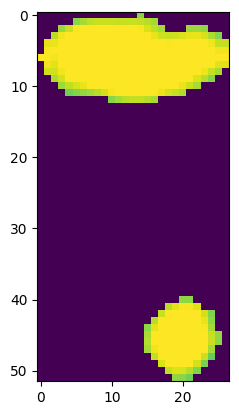

In [22]:
plt.imshow(masked_cropped)

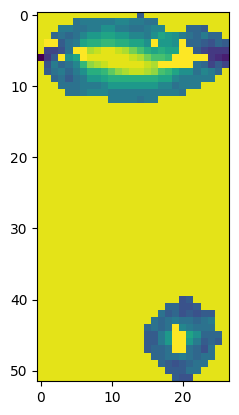

In [25]:
plt.imshow(lbp)

In [23]:
df

,Max,Mean,Variation,Median,Skewness,Kurtosis,Entropy,Contrast,Label
0,7382,260.000000,5.087032,7.5,5.198129,25.025508,0.352311,1875.996126,AVC
1,17614,1276.000000,2.610743,423.0,4.181938,16.828468,2.075806,4017.445065,AVC
2,2378,154.500000,2.787923,63.0,4.632449,20.756650,1.984861,10741.459406,AVC
3,499,44.333333,2.038898,24.0,4.277254,18.448069,2.422038,11275.691460,AVC
4,149,16.133333,1.860312,4.5,3.297153,10.933817,2.406548,15739.938235,AVC
...,...,...,...,...,...,...,...,...,...
557,1813,78.400000,4.116068,10.0,5.169110,24.829728,1.185711,9570.293087,EM
558,13861,488.366667,5.085284,13.5,5.197809,25.023339,0.353728,2609.844157,EM
559,12485,476.933333,4.678940,34.0,5.186873,24.949359,0.716785,6954.368429,EM
560,7794,313.600000,4.433827,25.0,5.183095,24.924273,0.935484,9119.625601,EM


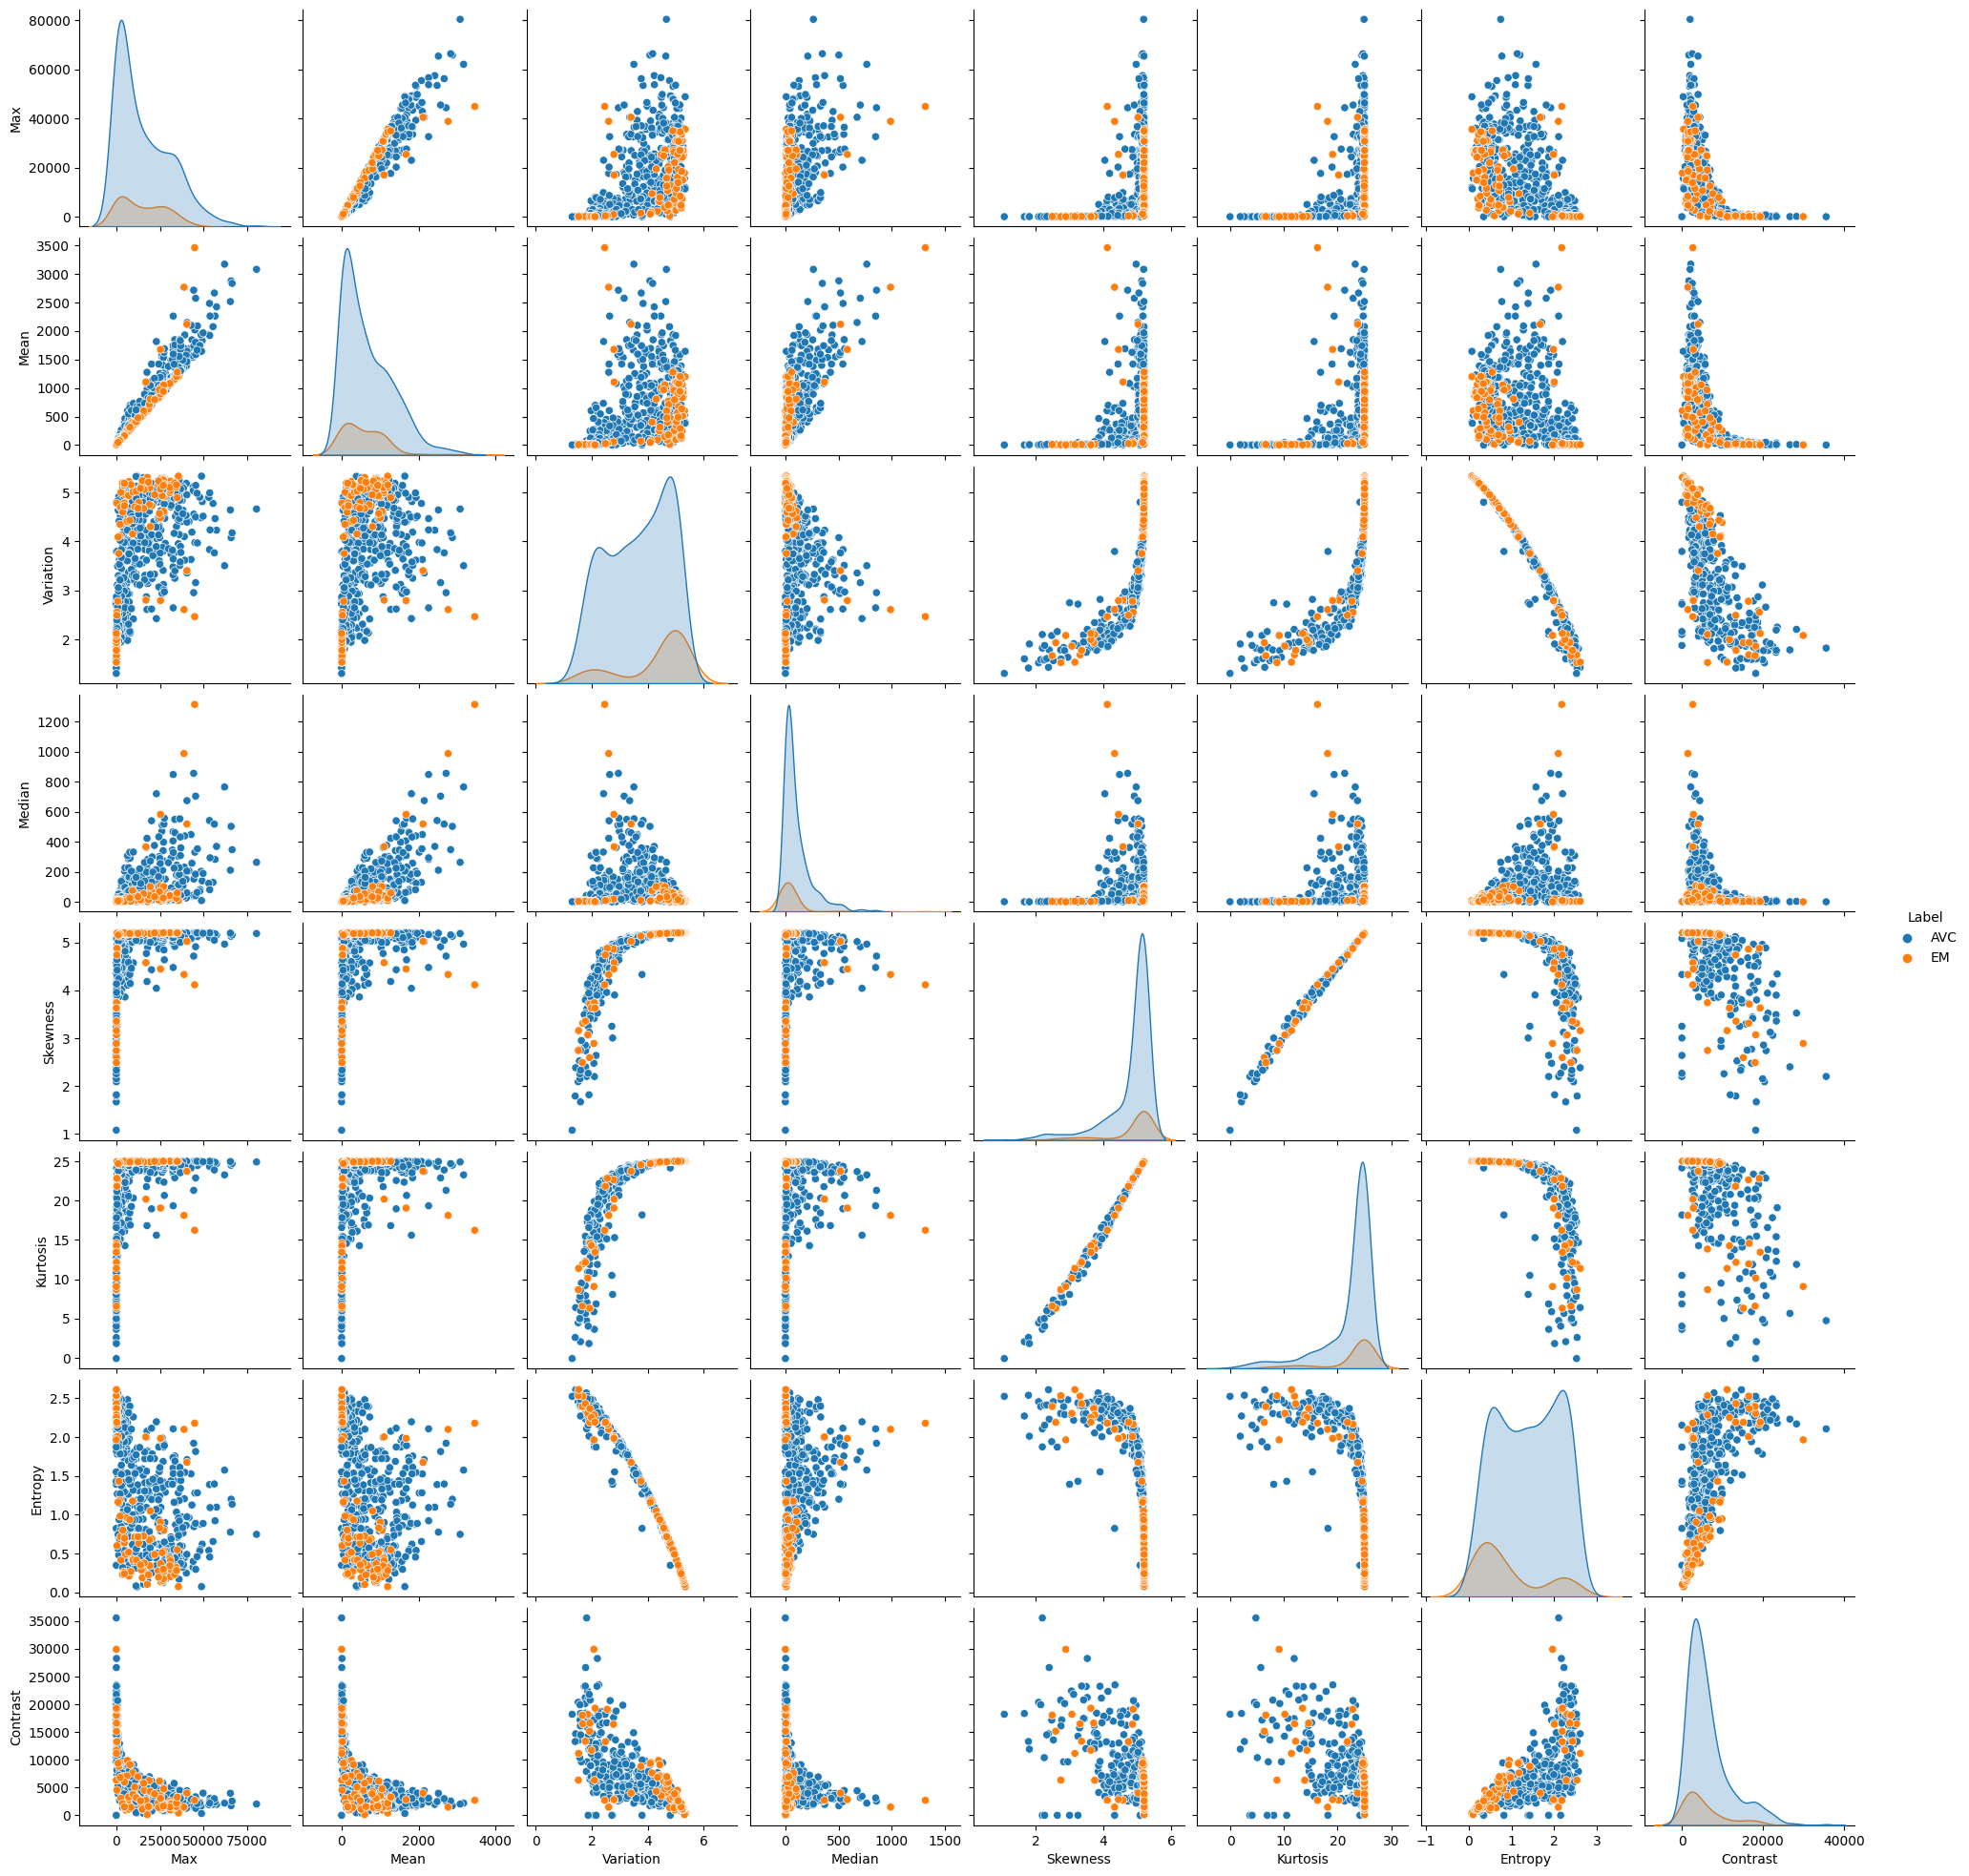

In [24]:
sns.pairplot(df, vars=['Max','Mean','Variation','Median','Skewness','Kurtosis','Entropy','Contrast'], hue='Label')